In [1]:
import pennylane as qml
from pennylane import numpy as np
from IPython.display import display, Latex

# from numba import jit

# numpy 
import numpy as np_
import scipy as sp

import random

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires = 2)

# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [2]:
# == Global paras ==
Tau_global = 1e-9
Paras_global, Phi_global, Gamma_ps  = np_.array([0] * 3), 0, 0

# Return one by one
def Dephase_factor(tau):
    Calculate_Dephase = 1 - np.exp(-2 * tau)
    
    return Calculate_Dephase

$$
\rho_{After-Hadamard} = 

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

where,
\quad \gamma = 
1 - e^{-2 \tau}
$$


$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [3]:
# == Generate circuit ==

# circuit_1
@qml.qnode(dev)
def circuit_1(paras):
    # Call global phi
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Assign paras
    theta_init, tau_1, tau_2 = paras[0], paras[1], paras[2]
    
    # Calculate dephase factor with fixed tau
    gamma_dephase_in = Dephase_factor(Tau_global)
    # print(gamma_dephase_in, Dephase_global)
        
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)
    qml.PhaseDamping(gamma_dephase_in, wires = 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)
    qml.PhaseDamping(gamma_dephase_in, wires = 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulater
    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)
    qml.PhaseDamping(gamma_dephase_in, wires = 1)
    
    qml.RY(-np.pi/2, wires=0)
    qml.RY(-np.pi/2, wires=1)
    
    return qml.density_matrix(wires=[0, 1])


# Circuit_2: Calculate decoherence by using [tau -> gamma_dephase_in] conversion
@qml.qnode(dev)
def Post_selection_Dephase(phi):
    
    # theta_init, tau_1, tau_2, gamma_1, gamma_2, gamma_3 = paras[0], paras[1], paras[2], paras[3], paras[4], paras[5]
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit_1(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    K_H = K.conj().T
    
    Numerator = sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H)
    Denominator = np.trace(sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H))
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=[0, 1])
    
    return qml.density_matrix(wires=[0, 1])  

$$ K =  \begin{bmatrix}
\sqrt{1-\gamma} & 0 \\
0 & 1 
\end{bmatrix}  $$


$$
\rho_{ps} = 
\frac{(K \otimes K) \rho (K^{\dagger} \otimes K ^{\dagger})}

{Tr[(K \otimes K) \rho (K^{\dagger} \otimes K ^{\dagger})]}
$$

![Alt text](image-1.png)

In [4]:
# == Cost function ==
def Cost_function(paras):
    # expect: theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3 = paras[0], paras[1], paras[2], paras[3], paras[4], paras[5]
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [5]:
# == Check for maximum tau <-> gamma ==
tau_test = 1e-9

print('Gamma =', Dephase_factor(tau_test), ', [ at tau =',tau_test,']' )

Gamma = 1.999999943436137e-09 , [ at tau = 1e-09 ]


In [6]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # Set Data index
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # Constraints(gamma = 0.99..) 
            tau_upper = 18
            Constraints = [(-float('inf'), float('inf'))] * 3 
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'L-BFGS-B', bounds = Constraints)
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

Data = 

array([ [PHI_0, CFI_0, theta_0, tau_1, tau_2, tau_d1, tau_d2, tau_d3], 

...

In [7]:
# == Fixed to gamma_ps = 0.8 ==

# == Sweep for 0 ~ pi*3 == 
Step = np.pi/25     #1e-1
Sweep_data = np_.array([1e-4, np.pi * 6 + 1e-4, Step])

Para_init = np_.zeros(3)
Para_init[:3] = random.uniform(0, 1)

Gamma_ps_preset = 0.8
Set_Iterations = 3

Optimized_Result = BFGS(Sweep_data, Para_init, Gamma_ps_preset, Set_Iterations)

In [8]:
# Optimized_Result[:, 0]

# layer = 0 & test_case = 3.01000000e-01
Current_Layer = 1
Optimized_Result[Current_Layer][:, :]

# Optimized_Result[0][:,:]

array([[ 1.00000000e-04,  9.99998644e+01, -6.78806988e-04,
         5.29128871e-05,  5.44389884e-01],
       [ 1.25763706e-01,  9.99889998e+01,  5.47186095e-07,
        -1.26822253e-01,  5.44382885e-01],
       [ 2.51427412e-01,  9.99787670e+01,  4.45296394e-07,
        -2.52918713e-01,  5.44382639e-01],
       [ 3.77091118e-01,  9.99698880e+01, -1.84753312e-09,
        -3.78864236e-01,  5.44382037e-01],
       [ 5.02754825e-01,  9.99629115e+01, -3.24368687e-09,
        -5.04717172e-01,  5.44381843e-01],
       [ 6.28418531e-01,  9.99582742e+01, -4.71238896e+00,
        -5.65268591e+00,  5.44381089e-01],
       [ 7.54082237e-01,  9.99562639e+01,  1.42890142e-08,
        -7.56217658e-01,  5.44381607e-01],
       [ 8.79745943e-01,  9.99569322e+01,  1.01074772e-07,
        -8.77626935e-01,  5.44382612e-01],
       [ 1.00540965e+00,  9.99604380e+01, -1.25118167e-08,
        -1.00744129e+00,  5.44382667e-01],
       [ 1.13107336e+00,  9.99661425e+01,  1.57079633e+02,
         7.11274354e+01

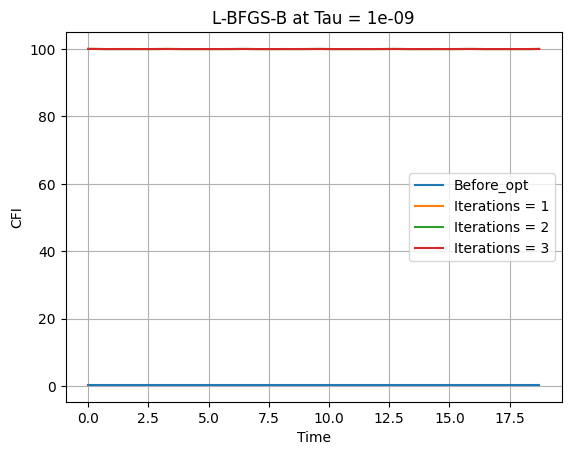

In [9]:
plt.plot(Optimized_Result[0, : ,0], Optimized_Result[0, : ,1], label = 'Before_opt')
for i in range(1, Set_Iterations + 1):
    plt.plot(Optimized_Result[0, :, 0], Optimized_Result[i, :, 1], label = f'Iterations = {i}')
    
plt.title(f'L-BFGS-B at Tau = {Tau_global}')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

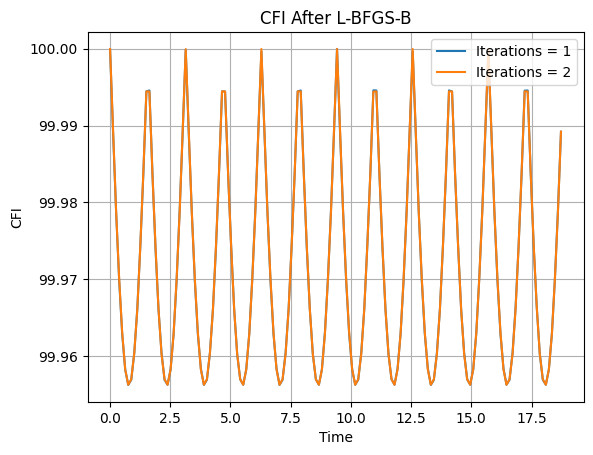

In [16]:
Target_Layer = 1, 2
plt.plot(Optimized_Result[Target_Layer[0], :, 0], Optimized_Result[Target_Layer[0], :, 1], label = f'Iterations = {Target_Layer[0]}')
plt.plot(Optimized_Result[Target_Layer[1], :, 0], Optimized_Result[Target_Layer[1], :, 1], label = f'Iterations = {Target_Layer[1]}')

plt.title('CFI After L-BFGS-B')
plt.xlabel('Time')
plt.ylabel('CFI')

plt.legend()
plt.grid() 

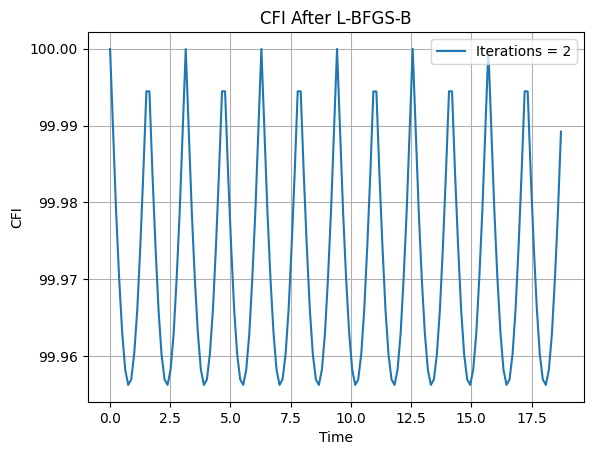

In [11]:
plt.plot(Optimized_Result[1, :, 0], Optimized_Result[Target_Layer[1], :, 1], label = f'Iterations = {Target_Layer[1]}')

plt.title('CFI After L-BFGS-B')
plt.xlabel('Time')
plt.ylabel('CFI')

plt.legend()
plt.grid() 

In [46]:
# == Check if optimized results are smaller than the past ==

Flag, Index, Count = 0, np_.zeros(len(Optimized_Result[0, :, 1])), 0
for i in range(len(Optimized_Result[2, :, 1])):
    Flag = 0 if Optimized_Result[3, i, 1] > Optimized_Result[1, i, 1]  else 1
    if Flag == 1:
        
        Index[Count] = i
        print(i)
        Count = Count+1

for i in range(len(Index)):
    print(Optimized_Result[1, int(Index[i]), 1], '  ', Optimized_Result[3, int(Index[i]), 1])

5
8
9
10
12
13
14
17
20
21
23
24
30
33
39
45
46
47
48
49
51
52
55
58
59
63
64
66
67
70
71
72
73
75
77
83
87
88
89
95
98
102
105
108
110
112
115
117
120
121
123
124
127
130
133
134
137
138
141
142
144
145
146
147
148
99.95827423826017    99.95827347172762
99.96043798655924    99.96043795761696
99.96614254964894    99.96614251363339
99.97436935879828    99.97436899351571
99.99444806446445    99.99444612731834
99.99456307726385    99.99442843256885
99.98375566621719    99.98375563560771
99.96043039188916    99.96027839458884
99.9582797733369    99.95827967117211
99.96292083763235    99.96292075312614
99.97901281176341    99.97878508626131
99.98920072128335    99.98919636955868
99.95838694744073    99.95827442957382
99.96043798655924    99.96043795761696
99.98375561423867    99.98375529047527
99.95827979761192    99.95827950718873
99.96292081217314    99.9629206086222
99.97012672074568    99.97012563834775
99.97901255546698    99.97877690049967
99.98920099528841    99.98920013109434
99.989

Each row of 6-paras => Corresponds to phi

func(phi, paras, gamma_ps)
=> Implement on SLSQP 

Data = [[phi, CFI, theata_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3] ... N]

In [13]:
# Bad case after optimization
# 

Num_of_Layer = 1
Condition = np_.where(Optimized_Result[Num_of_Layer][:, 1] < 98)

print('Index:\n', Condition[0])

print('\n')

Optimized_Result[Num_of_Layer, Condition[0], 1]

print('PHI:\n', Optimized_Result[Num_of_Layer, Condition[0], 0], '\n\nCFI\n', Optimized_Result[Num_of_Layer, Condition[0], 1], '\n\nParas\n', Optimized_Result[Num_of_Layer, Condition[0], 2:])

Index:
 []


PHI:
 [] 

CFI
 [] 

Paras
 []
